In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/')

## Data preparing

In [ ]:
data = pd.read_csv('final_data.csv')

In [ ]:
data.drop('Unnamed: 0' ,axis=1, inplace=True)

In [ ]:
data.head()

,Year,Month,Day,Hour,Air pressure,Air temperature,RAD radiation,Precipitation,Realtive humidity,UVB radiation,CO,NO2,NOx,O3,PM2.5,PM10,SO2,C6H6
0,2015,1,1,0,1012.0,-6.6,0.0,62.8,1.6,278.0,0.575,18.0,20.0,7.0,19.0,NaN,35.778146,5.01000
1,2015,1,1,1,1011.0,-7.4,0.0,69.6,1.5,279.0,0.581,20.0,25.0,7.0,13.0,50.0,244.272000,5.25388
2,2015,1,1,2,1011.0,-7.1,0.0,72.3,1.4,286.0,0.678,20.0,25.0,6.0,11.0,34.0,102.633000,4.74133
3,2015,1,1,3,1012.0,-6.5,0.2,71.0,1.5,292.0,0.686,21.0,24.0,6.0,9.0,29.0,77.725900,4.66580
4,2015,1,1,4,1012.0,-5.6,0.0,69.2,1.7,299.0,0.653,22.0,25.0,6.0,10.0,21.0,69.562100,4.77038


In [ ]:
def prepare_data(data):
  #Preparing dataset for model
  data2015 = data[data.Year==2015]
  data_2015_by_day = data2015.groupby(['Month','Day']).mean()
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day = data_2015_by_day['NOx']
  data2016 = data[data.Year==2016]
  data_2016_by_day = data2016.groupby(['Month','Day']).mean()
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day = data_2016_by_day['NOx']
  data2017 = data[data.Year==2017]
  data_2017_by_day = data2017.groupby(['Month','Day']).mean()
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day = data_2017_by_day['NOx']
  combine = [data_2015_by_day,data_2016_by_day,data_2017_by_day]
  data = pd.concat(combine)
  return data

In [ ]:
data = prepare_data(data)

In [ ]:
NOx_timestamp = np.arange(1,data.shape[0]+1)
NOx_by_day = data

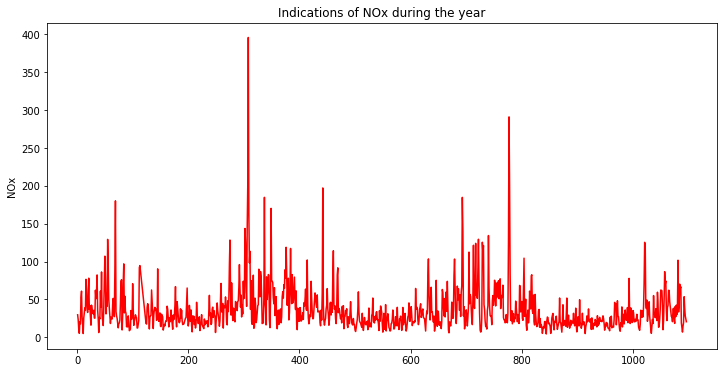

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(NOx_timestamp, NOx_by_day, color='red')
plt.title('Indications of NOx during the year')
plt.show()

In [ ]:
NOx_by_day_ori = NOx_by_day[0:1093]
NOx_by_day  = NOx_by_day[0:1093]

In [ ]:
NOx_by_day = NOx_by_day.reset_index(drop=True)


## Dataset differencing


In [ ]:
def difference(dataset, interval=1):
  #Creating a differenced series
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
NOx_by_day = difference(NOx_by_day.values)

In [ ]:
train, test = NOx_by_day[0:728], NOx_by_day[728:1092]

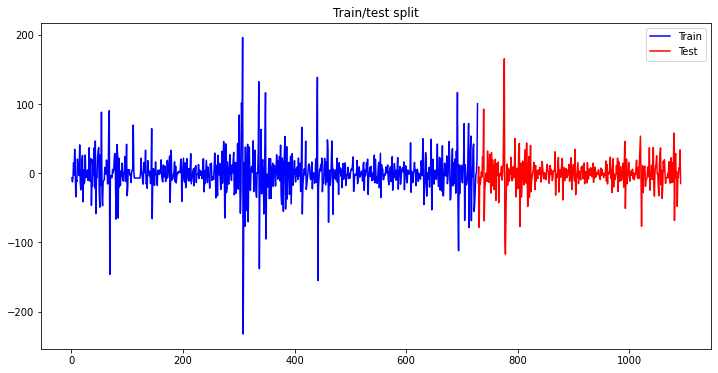

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(NOx_timestamp[0:728], train, color='blue', label='Train')
sns.lineplot(NOx_timestamp[728:1092], test, color='red', label='Test')
plt.title('Train/test split')
plt.show()

## Naive forecasts

In [ ]:
naive_forecast = NOx_by_day[728 - 7:1085]
validation = NOx_by_day[728:1092]

Text(0.5, 1.0, 'Naive annual forecasts for NOx')

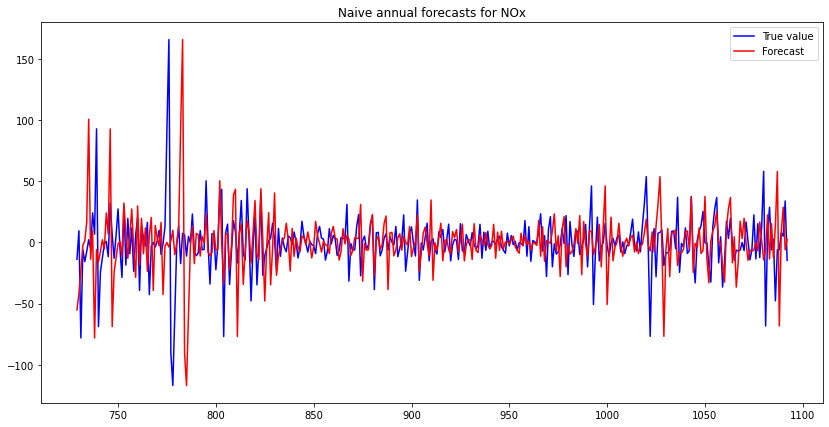

In [ ]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(NOx_timestamp[728:1092], validation, color='blue', label='True value')
ax2 = sns.lineplot(NOx_timestamp[728:1092], naive_forecast, color='red', label='Forecast')
plt.title('Naive annual forecasts for NOx')

In [ ]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(validation, naive_forecast))))
print('Annual MAE: {}'.format(mean_absolute_error(validation, naive_forecast)))

Annual RMSE: 29.62607577951669
Annual MAE: 19.372458297847984


In [ ]:
def daily_persistance(history):
  #Simple model performance indicator
  last_hours = np.array(history[:7])
  value = last_hours[-1]
  forecast = [value for _ in range(7)]
  return forecast

In [ ]:
forecast = daily_persistance(test)
print(forecast)

In [ ]:
validation = test[7:14]
print(validation)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(validation,forecast)
print('RMSE: {}'.format(np.sqrt(mse)))

## MIN MAX SCALER

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Scaling data to range (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
NOx_by_day_scaled = np.array(NOx_by_day)
NOx_by_day_scaled = scaler.fit_transform(NOx_by_day_scaled.reshape(-1,1))

In [ ]:
train_scaled, test_scaled = NOx_by_day_scaled[0:728], NOx_by_day_scaled[728:1092]

## LSTM approach

In [ ]:
train_scaled = np.array(np.split(train_scaled,len(train_scaled)/7))
test_scaled = np.array(np.split(test_scaled,len(test_scaled)/7))
train_features = [train_scaled for i in range(10)]

In [ ]:
train = np.dstack(train_features)

In [ ]:
def to_supervised(train, n_input, n_out=7):
  #Transform data for supervised learning problem
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		in_start += 1
	return np.array(X), np.array(y)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

train_x, train_y = to_supervised(train, 7)
verbose, epochs, batch_size = 1, 100, 21
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=Adam(learning_rate=8e-6))

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=lr_schedule)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 100)            120400    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            10100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 613,001
Trainable params: 613,001
Non-trainable params: 0
__________________________________________________

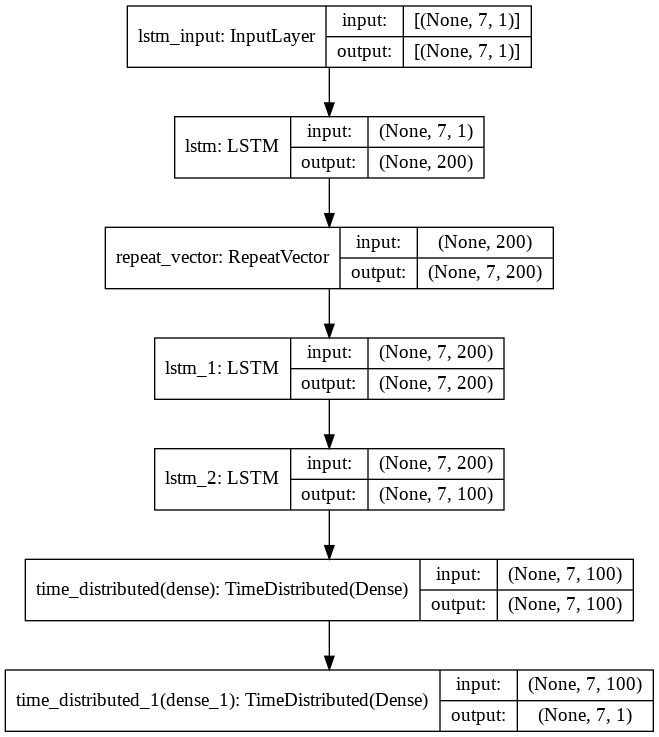

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

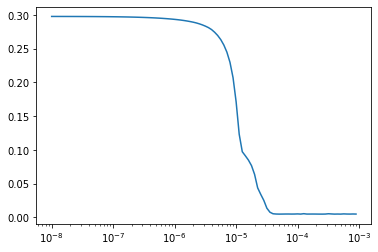

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])

In [ ]:
def build_model(train, n_input):
  #Training model build
  train_x, train_y = to_supervised(train, n_input)
  verbose, epochs, batch_size = 1, 1000, 21
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
  
  history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model, history

In [ ]:
model = build_model(train, 7)

Epoch 1/1000
35/35 [==============================] - 5s 45ms/step - loss: 0.2876
Epoch 2/1000
35/35 [==============================] - 2s 45ms/step - loss: 0.2219
Epoch 3/1000
35/35 [==============================] - 2s 46ms/step - loss: 0.0862
Epoch 4/1000
35/35 [==============================] - 2s 46ms/step - loss: 0.0611
Epoch 5/1000
35/35 [==============================] - 2s 46ms/step - loss: 0.0355
Epoch 6/1000
35/35 [==============================] - 2s 48ms/step - loss: 0.0219
Epoch 7/1000
35/35 [==============================] - 2s 47ms/step - loss: 0.0135
Epoch 8/1000
35/35 [==============================] - 2s 47ms/step - loss: 0.0068
Epoch 9/1000
35/35 [==============================] - 2s 46ms/step - loss: 0.0047
Epoch 10/1000
35/35 [==============================] - 2s 48ms/step - loss: 0.0049
Epoch 11/1000
35/35 [==============================] - 2s 47ms/step - loss: 0.0046
Epoch 12/1000
35/35 [==============================] - 2s 46ms/step - loss: 0.0049
Epoch 13/1000

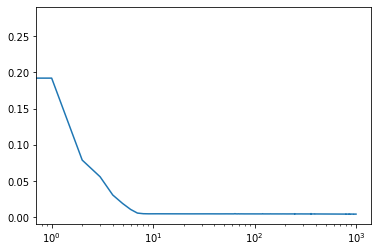

In [ ]:
plt.semilogx(model[1].epoch, model[1].history['loss'])

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_model(input, validation, model, scaler):
  #Model evaluation on test data
  input = input.reshape(1,len(input), 1)
  validation = validation.reshape(1,len(validation), 1)
  forecast = model[0].predict(input)
  forecast = forecast.flatten()
  validation = validation.flatten()
  
  validation = scaler.inverse_transform(validation.reshape(-1,1))
  forecast = scaler.inverse_transform(forecast.reshape(-1,1))

  days = ['Piatek', 'Sobota', 'Niedziela', 'Poniedzialek', 'Wtorek', 'Sroda', 'Czwartek']
  for i in range(validation.shape[0]):
    mse = mean_squared_error(validation[i, :], forecast[i,:])
    rmse = np.sqrt(mse)
    print('{} : RMSE:{}'.format(days[i],rmse))

  rmse = np.sqrt(mean_squared_error(validation, forecast))
  
  print('\nWeek RMSE:{}'.format(rmse))
  
  x = np.arange(1,8)
  plt.figure(figsize = (12,6))
  sns.lineplot(days, forecast.flatten(), label = 'Forecast', color='red')
  sns.lineplot(days, validation.flatten(), label = 'True value', color='blue')
  plt.show()

Piatek : RMSE:11.99064395151774
Sobota : RMSE:16.0324208775838
Niedziela : RMSE:1.9998890398661278
Poniedzialek : RMSE:89.1337376726786
Wtorek : RMSE:72.56098302815754
Sroda : RMSE:28.176530522155772
Czwartek : RMSE:16.9678472671509

Week RMSE:45.820391250436614


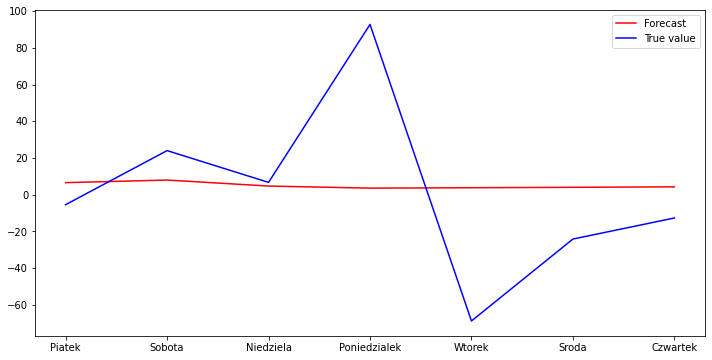

In [ ]:
input = NOx_by_day_scaled[728:735]
validation = NOx_by_day_scaled[735:742]
evaluate_model(input, validation, model, scaler)

Piatek : RMSE:12.465671650899225
Sobota : RMSE:5.092061658426904
Niedziela : RMSE:11.95051284467537
Poniedzialek : RMSE:33.29617219936371
Wtorek : RMSE:8.589365952428174
Sroda : RMSE:9.977241616694124
Czwartek : RMSE:9.078661008199036

Week RMSE:15.531150934566979


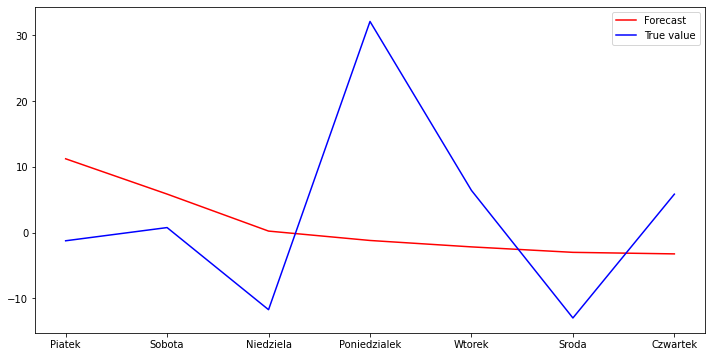

In [ ]:
input1 = NOx_by_day_scaled[735:742]
validation1 = NOx_by_day_scaled[742:749]
evaluate_model(input1, validation1, model, scaler)

Piatek : RMSE:23.927185841369607
Sobota : RMSE:4.783516731421126
Niedziela : RMSE:27.571317909177154
Poniedzialek : RMSE:29.99411077858608
Wtorek : RMSE:18.05687730512622
Sroda : RMSE:20.653504369036344
Czwartek : RMSE:7.874591203435262

Week RMSE:20.94156412022217


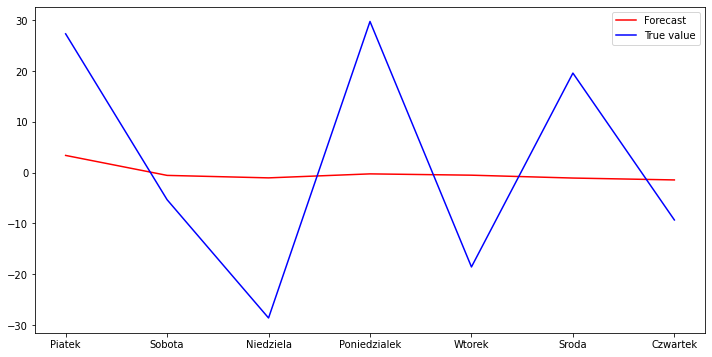

In [ ]:
input2 = NOx_by_day_scaled[742:749]
validation2 = NOx_by_day_scaled[749:756]
evaluate_model(input2, validation2, model, scaler)

Piatek : RMSE:7.758724726613353
Sobota : RMSE:23.75386928284962
Niedziela : RMSE:6.66932684917453
Poniedzialek : RMSE:20.4476011398196
Wtorek : RMSE:38.89431565844216
Sroda : RMSE:14.775235498046888
Czwartek : RMSE:4.904575114885953

Week RMSE:20.150004111673393


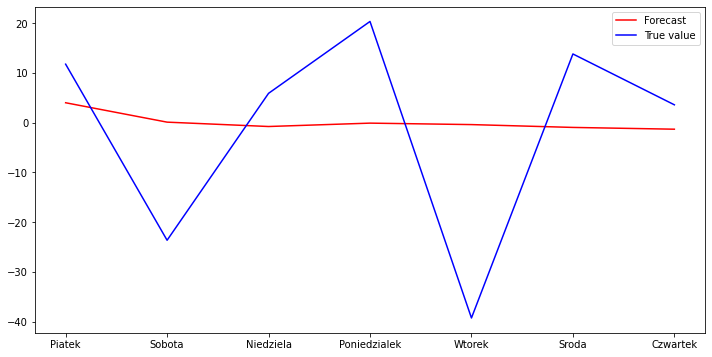

In [ ]:
input3 = NOx_by_day_scaled[749:756]
validation3 = NOx_by_day_scaled[756:763]
evaluate_model(input3, validation3, model, scaler)

Piatek : RMSE:7.8807471799214355
Sobota : RMSE:15.1165356812159
Niedziela : RMSE:42.15542255868912
Poniedzialek : RMSE:3.043803679092713
Wtorek : RMSE:0.16026695173580596
Sroda : RMSE:2.9989007109960064
Czwartek : RMSE:2.1552941648483017

Week RMSE:17.281801340307865


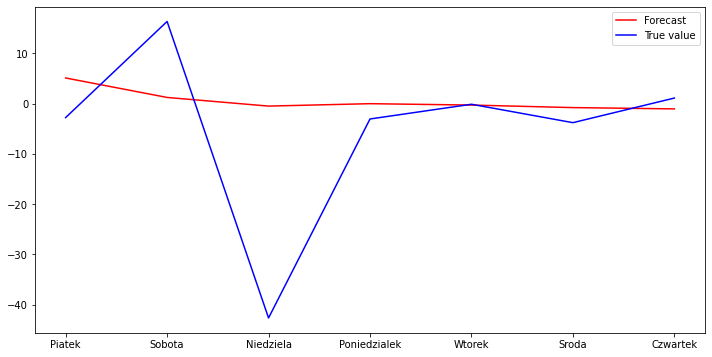

In [ ]:
input = NOx_by_day_scaled[756:763]
validation = NOx_by_day_scaled[763:770]
evaluate_model(input, validation, model, scaler)

Piatek : RMSE:4.171801711273204
Sobota : RMSE:12.892758615366636
Niedziela : RMSE:1.9654852906544775
Poniedzialek : RMSE:11.502523391342141
Wtorek : RMSE:91.94666082750959
Sroda : RMSE:164.50351762555437
Czwartek : RMSE:91.69389713668822

Week RMSE:79.50127119527458


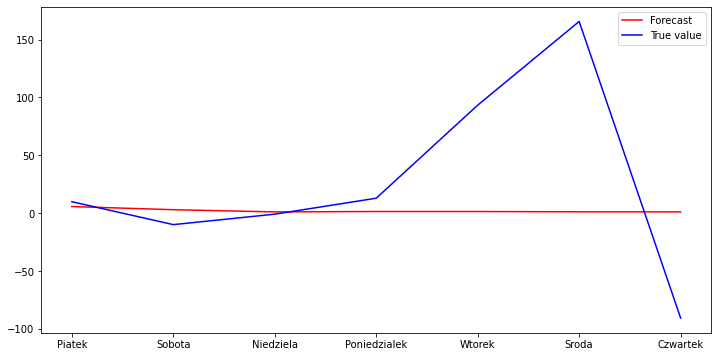

In [ ]:
input5 = NOx_by_day_scaled[763:770]
validation5 = NOx_by_day_scaled[770:777]
evaluate_model(input5, validation5, model, scaler)

## Six last weeks

Piatek : RMSE:2.9887856897989735
Sobota : RMSE:24.918260692443837
Niedziela : RMSE:3.8242957319641153
Poniedzialek : RMSE:8.659303973499924
Wtorek : RMSE:12.20826551607769
Sroda : RMSE:23.82561097362517
Czwartek : RMSE:1.5981812388102525

Week RMSE:14.336352432275065


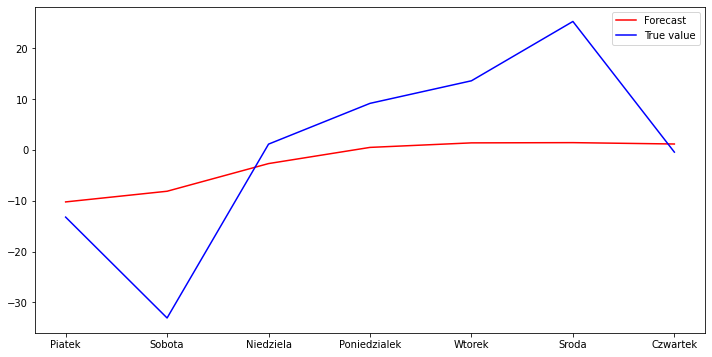

In [ ]:
input7 = NOx_by_day_scaled[1036:1043]
validation7 = NOx_by_day_scaled[1043:1050]
evaluate_model(input7, validation7, model, scaler)

Piatek : RMSE:14.927556320190446
Sobota : RMSE:8.901268928019228
Niedziela : RMSE:29.519808254903147
Poniedzialek : RMSE:11.39232616760253
Wtorek : RMSE:25.025954822769137
Sroda : RMSE:33.889703017934174
Czwartek : RMSE:19.271666184234636

Week RMSE:22.198700747335575


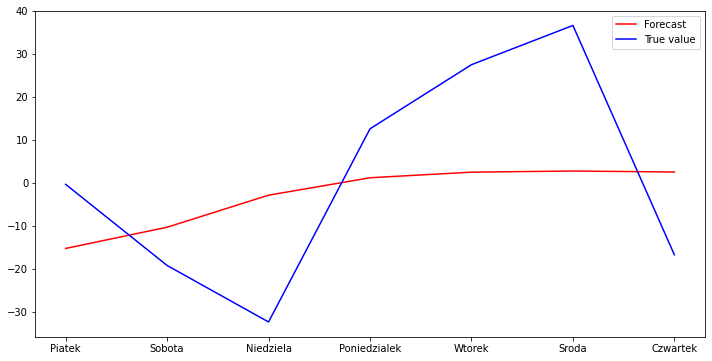

In [ ]:
input8 = NOx_by_day_scaled[1043:1050]
validation8 = NOx_by_day_scaled[1050:1057]
evaluate_model(input8, validation8, model, scaler)

Piatek : RMSE:19.54244520975748
Sobota : RMSE:26.361221866861975
Niedziela : RMSE:13.082715161615988
Poniedzialek : RMSE:16.138597205963137
Wtorek : RMSE:0.763253044204693
Sroda : RMSE:17.060163491744994
Czwartek : RMSE:2.471916007995587

Week RMSE:16.0631567845344


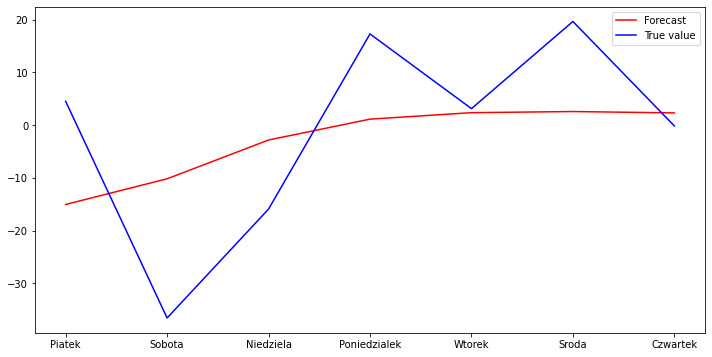

In [ ]:
input9 = NOx_by_day_scaled[1050:1057]
validation9 = NOx_by_day_scaled[1057:1064]
evaluate_model(input9, validation9, model, scaler)

Piatek : RMSE:8.037168085225444
Sobota : RMSE:0.4936700294494454
Niedziela : RMSE:5.351761290931719
Poniedzialek : RMSE:7.461855877049787
Wtorek : RMSE:1.958905976994809
Sroda : RMSE:8.763353877334609
Czwartek : RMSE:14.901450314420082

Week RMSE:8.034277710022517


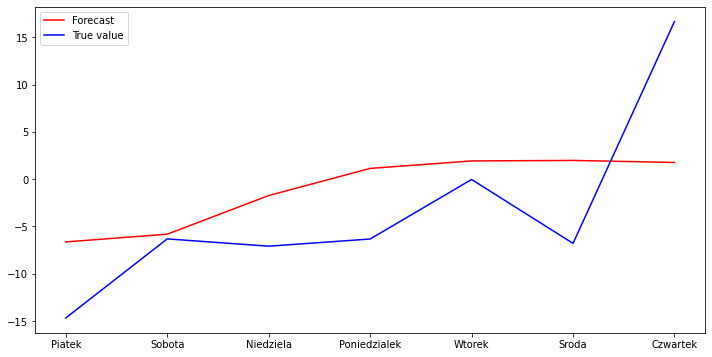

In [ ]:
input10 = NOx_by_day_scaled[1057:1064]
validation10 = NOx_by_day_scaled[1064:1071]
evaluate_model(input10, validation10, model, scaler)

Piatek : RMSE:0.9250245172754636
Sobota : RMSE:13.80151069794975
Niedziela : RMSE:5.365566712884903
Poniedzialek : RMSE:21.239971031328835
Wtorek : RMSE:14.933247048276291
Sroda : RMSE:13.965475080782591
Czwartek : RMSE:13.512713558286046

Week RMSE:13.479576258761615


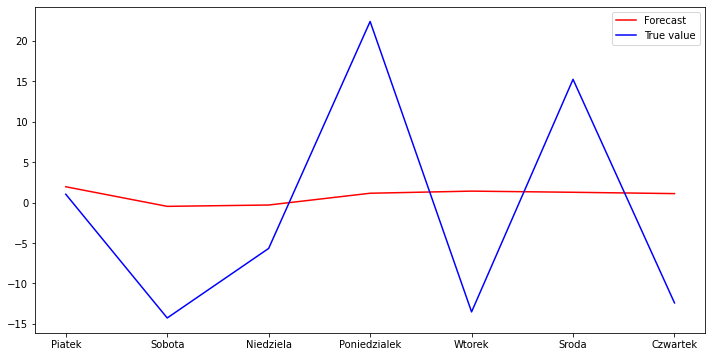

In [ ]:
input11 = NOx_by_day_scaled[1064:1071]
validation11 = NOx_by_day_scaled[1071:1078]
evaluate_model(input11, validation11, model, scaler)

Piatek : RMSE:9.835786628697717
Sobota : RMSE:57.20681917263667
Niedziela : RMSE:68.18682966289522
Poniedzialek : RMSE:7.3211954039827845
Wtorek : RMSE:28.02000669273376
Sroda : RMSE:6.390296292034797
Czwartek : RMSE:2.487153508243948

Week RMSE:35.66620868635508


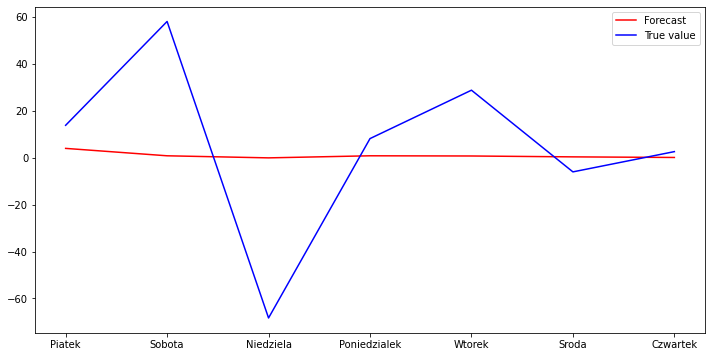

In [ ]:
input12 = NOx_by_day_scaled[1071:1078]
validation12 = NOx_by_day_scaled[1078:1085]
evaluate_model(input12, validation12, model, scaler)

Piatek : RMSE:47.6685703743577
Sobota : RMSE:3.268808463592542
Niedziela : RMSE:4.401552531598397
Poniedzialek : RMSE:7.774999941417232
Wtorek : RMSE:4.95008612223784
Sroda : RMSE:33.971315493416775
Czwartek : RMSE:14.277707177880613

Week RMSE:23.130711033207835


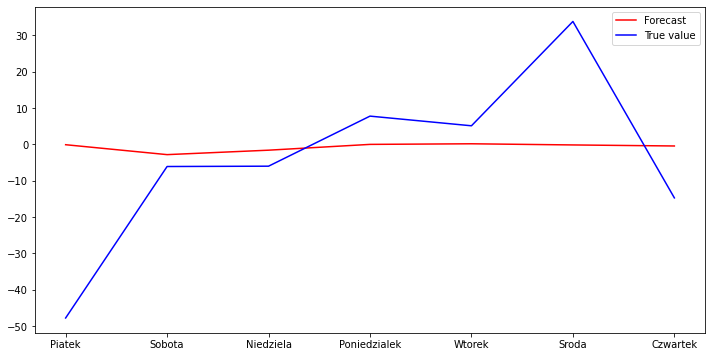

In [ ]:
input13 = NOx_by_day_scaled[1078:1085]
validation13 = NOx_by_day_scaled[1085:1092]
evaluate_model(input13, validation13, model, scaler)

## How model learn?

Piatek : RMSE:39.01498285929361
Sobota : RMSE:62.572308858235694
Niedziela : RMSE:42.37511761983235
Poniedzialek : RMSE:2.6165421803792297
Wtorek : RMSE:26.815573771794625
Sroda : RMSE:44.98414444923399
Czwartek : RMSE:67.35282079378763

Week RMSE:45.54277475557288


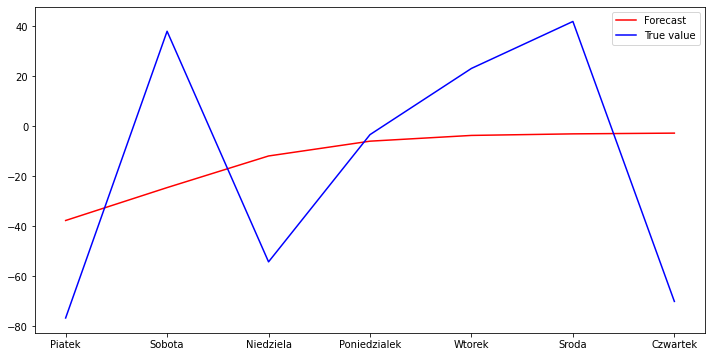

In [ ]:
input = NOx_by_day_scaled[303:310]
validation = NOx_by_day_scaled[310:317]
evaluate_model(input, validation, model, scaler)

Piatek : RMSE:35.632725397745766
Sobota : RMSE:97.24754508336383
Niedziela : RMSE:56.349948664506286
Poniedzialek : RMSE:196.56713611384234
Wtorek : RMSE:231.23620963096621
Sroda : RMSE:63.61116588115692
Czwartek : RMSE:17.747950712839735

Week RMSE:125.56858494877493


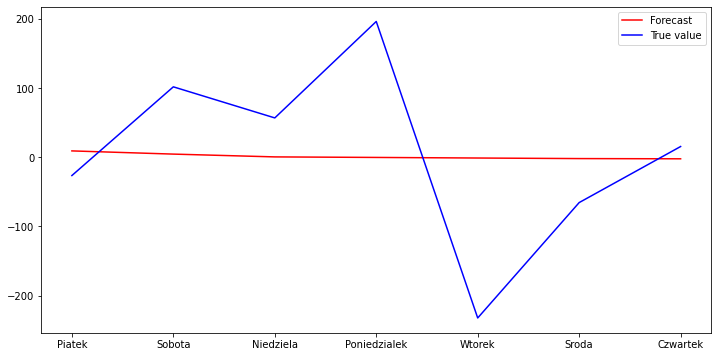

In [ ]:
input = NOx_by_day_scaled[296:303]
validation = NOx_by_day_scaled[303:310]
evaluate_model(input, validation, model, scaler)

## NOx annual forecast obtained with LSTM

In [ ]:
 first_week = np.array([0.41319406, 0.444344, 0.4885545, 0.53594196, 0.54503354, 0.58086161, 0.77665637])

def annual_forecast(test_data, first_week, original_data = NOx_by_day_ori, undiff=False):
  first_week = first_week.reshape(1,7,1)
  forecasts = []
  validation = test_data
  forecasts.append(model[0].predict(first_week))

  for i in validation:
    i = i.reshape(1,7,1)
    forecasts.append(model[0].predict(i))

  forecasts.pop()
  forecasts = (np.array(forecasts)).flatten()
  forecasts = scaler.inverse_transform(forecasts.reshape(-1,1))
  forecasts = forecasts.flatten()

  validation = test_data.flatten()
  days = np.arange(1, len(forecasts)+1)
  validation = scaler.inverse_transform(validation.reshape(-1,1))

  if undiff==True:
    
    undiff_data = original_data[728:1092]
    undiff_data = np.array(undiff_data)
    undiff_forecasts = []
    
    for i in range(364):
      if i == 0 :
        x = undiff_data[i] + forecasts[i]
        undiff_forecasts.append(x)
      else:
        x = undiff_data[i] + forecasts[i]
        undiff_forecasts.append(x)

    validation = np.array(original_data[729:1093]).flatten()
    forecasts = np.array(undiff_forecasts)  

  plt.figure(figsize = (18,10))
  sns.lineplot(days, forecasts.flatten(), label = 'Forecast', color='red')
  sns.lineplot(days, validation.flatten(), label = 'True value', color='blue')
  plt.xlabel('Day of year', fontsize=12)
  plt.ylabel('NOx', fontsize=12)
  plt.title('Annual forecasts for NOx', fontsize=16)
  print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(validation, forecasts))))
  print('Annual MAE: {}'.format(mean_absolute_error(validation, forecasts)))

  plt.show()

Annual RMSE: 21.81608594725807
Annual MAE: 13.78397391014069


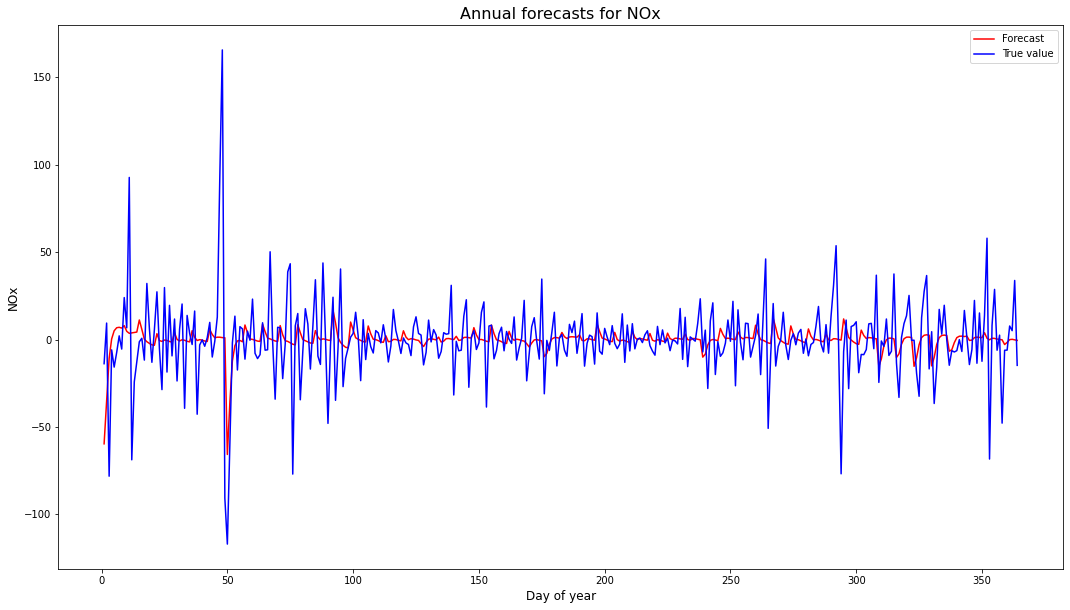

In [ ]:
annual_forecast(test_scaled, first_week, undiff=False)

Annual RMSE: 21.81608594725807
Annual MAE: 13.783973910140693


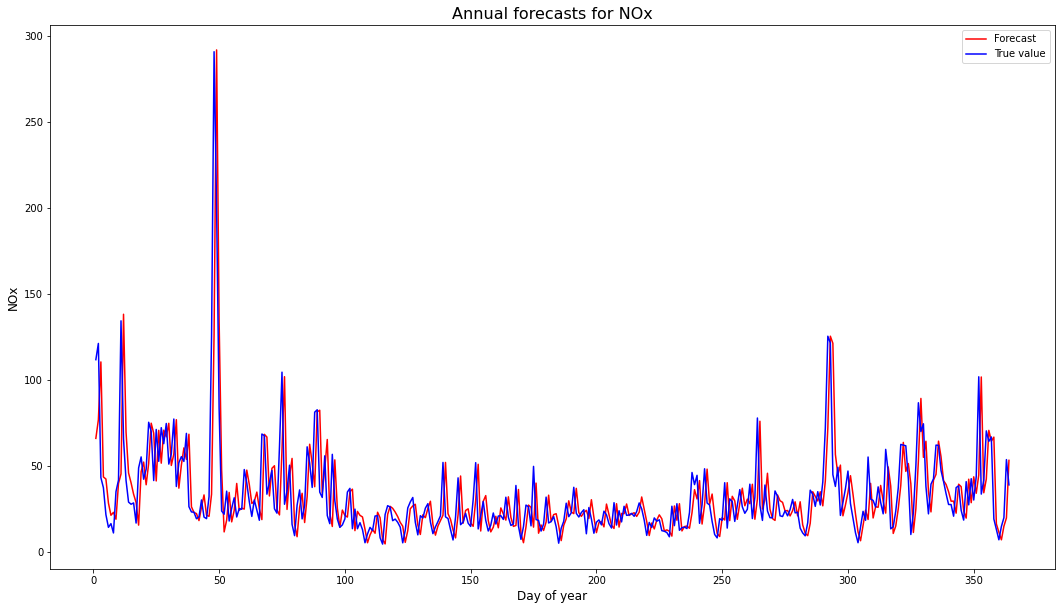

In [ ]:
annual_forecast(test_scaled, first_week, undiff=True)